#  Spam Classification of Emails

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score , classification_report, confusion_matrix



## Read the data

In [31]:
data = pd.read_csv('spam.tsv',sep = '\t',names = ['Class','Message'])
data.head(10)

,Class,Message
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,ham,Even my brother is not like to speak with me. ...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!!
5,ham,As per your request 'Melle Melle (Oru Minnamin...
6,spam,WINNER!! As a valued network customer you have...
7,spam,Had your mobile 11 months or more? U R entitle...
8,ham,I'm gonna be home soon and i don't want to tal...
9,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


## Get info on the data /// EDA

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5567 entries, 0 to 5566
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Class    5567 non-null   object
 1   Message  5567 non-null   object
dtypes: object(2)
memory usage: 87.1+ KB


In [33]:
data.describe()

,Class,Message
count,5567,5567
unique,2,5164
top,ham,"Sorry, I'll call later"
freq,4821,30


In [34]:
data.Class.value_counts()

ham     4821
spam     746
Name: Class, dtype: int64

<AxesSubplot:xlabel='Class', ylabel='count'>

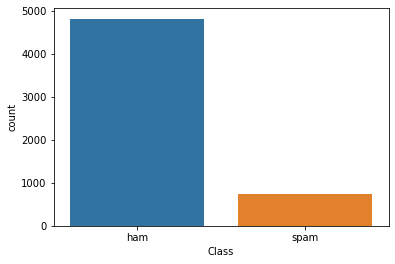

In [35]:
sns.countplot(x=data['Class'])

* By looking at the countplot, it is clear that our dataset is highly imbalanced. It might be in need of Feature engineering by oversampling the available data.

* Let us find out the length of the message to try to understand and categorize our messages. This obtained length will be added as a new column to the present dataframe.

In [36]:
data['Length'] = data['Message'].apply(len)

In [37]:
data.head()

,Class,Message,Length
0,ham,I've been searching for the right words to tha...,196
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
2,ham,"Nah I don't think he goes to usf, he lives aro...",61
3,ham,Even my brother is not like to speak with me. ...,77
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!!,36


* Let's check out what information does the length of the message can give us.

In [38]:
data['Length'].describe()

count    5567.000000
mean       80.450153
std        59.891023
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: Length, dtype: float64

* The longest message is of 910 characters long.
* The shortest is of 2 characters long.

In [39]:
data[data.Length==910]['Message'].values

array(["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."],
      dtype=object)

## Data Preprocessing

* The class label has to be encoded for the algorithm to run better on the dataset. The map function is used instead of a LabelEncoder to get more clarity.


In [40]:
classDict = {'ham':0, 'spam':1}

data.Class = data.Class.map(classDict)

* The next step is to tokenize the message and clean the text by eliminating the punctuation and special characters present in the text.
* The word_tokenize module from the nltk library helps in the tokenization of the message and also identify the stopwords.
* The Python's built-in string library gives us a quick list of all the special characters and this can be used to our advantage in eliminating the same. 
* User defined function to find the 'lemmas' , to eliminate the special characters,and to convert into lower case is defined and applied to the whole dataframe.

In [41]:
def TokenizeandClean(message):
    '''
    arg     : message(string)
    returns : tokenized, cleaned message
    
    The message is tokenized, converted into lower case letters and cleaned off of the punctuations
    '''
    wordToken = word_tokenize(message)
    text = [stemmer.stem(char.lower()) for char in wordToken if char.lower() not in stopwords.words('english') and char.lower().isalpha()]
    text = ' '.join(text)
    words = [chars for chars in text if chars not in string.punctuation ]
    words =''.join(words)
    return words

data.Message = data.Message.apply(TokenizeandClean)


In [42]:
data.head()

,Class,Message,Length
0,0,search right word thank breather promis wont t...,196
1,1,free entri wkli comp win fa cup final tkts may...,155
2,0,nah think goe usf live around though,61
3,0,even brother like speak treat like aid patent,77
4,0,date sunday,36


The messages have to be vectorized to be used in the machine learning models. Hence we use the CountVectorizer from Scikit Learn's feature extraction module.
The transformation will be done after splitting the datas into training and testing sets.

In [43]:
cv = CountVectorizer(stop_words='english')

In [44]:
x = data['Message']
y = data['Class']

### Splitting into Train and Test datas

In [45]:
xTrain,xTest,yTrain,yTest = train_test_split(x,y,test_size=0.2, random_state=42)

In [46]:
xTrain.values

array(['free rington repli real poli eg pushbutton dontcha babygoodby golddigg webeburnin tone free u join',
       'hello sort town alreadi dont rush home eat nacho let know eta',
       'arr birthday today wish get oscar', ...,
       'realis busi guy tri bother get exam outta way tri car day',
       'dunno lei shd b drive lor cos go sch hr oni',
       'dude ive see lotta corvett late'], dtype=object)

In [47]:
xTrain = cv.fit_transform(xTrain.values)
xTest = cv.transform(xTest.values)

## Model Building

I have used 
* Naive Baye's
* XGBoost Classifier
* RandomForest Classifier
* LogisticRegression

algorithms to build the machine learning model.

In [49]:
NB = MultinomialNB().fit(xTrain,yTrain)
ypredictNB = NB.predict(xTest)

confusion_matrix(yTest,ypredictNB)
print(classification_report(yTest,ypredictNB))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       969
           1       0.90      0.97      0.93       145

    accuracy                           0.98      1114
   macro avg       0.95      0.98      0.96      1114
weighted avg       0.98      0.98      0.98      1114



In [50]:
XGB = XGBClassifier().fit(xTrain,yTrain)
ypredictXGB = XGB.predict(xTest)

print(classification_report(yTest,ypredictXGB))

[16:43:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/thamanna/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       969
           1       0.97      0.88      0.92       145

    accuracy                           0.98      1114
   macro avg       0.98      0.94      0.95      1114
weighted avg       0.98      0.98      0.98      1114



In [51]:
RF = RandomForestClassifier(random_state=42).fit(xTrain,yTrain)
ypredictRF = RF.predict(xTest)

print(classification_report(yTest,ypredictRF))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       969
           1       0.98      0.86      0.92       145

    accuracy                           0.98      1114
   macro avg       0.98      0.93      0.95      1114
weighted avg       0.98      0.98      0.98      1114



In [52]:
LR = LogisticRegression().fit(xTrain,yTrain)
ypredictLR = LR.predict(xTest)

print(classification_report(yTest,ypredictLR))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       969
           1       0.99      0.89      0.94       145

    accuracy                           0.98      1114
   macro avg       0.99      0.94      0.96      1114
weighted avg       0.98      0.98      0.98      1114



In [53]:
accNB = accuracy_score(yTest,ypredictNB)*100
accXGB = accuracy_score(yTest,ypredictXGB)*100
accRF = accuracy_score(yTest,ypredictRF)*100
accLR = accuracy_score(yTest,ypredictLR)*100

In [54]:
accNB , accXGB , accRF , accLR

(98.20466786355476, 98.02513464991023, 98.02513464991023, 98.47396768402155)

From above code outputs it can be concluded that the Logistic Regression algorithm yields the highest accuracy.

## Spam Classification Application

In [60]:
msg = input('Enter the message :')
print('\n\n')
msg = TokenizeandClean(msg)
msginput = cv.transform([msg])
ypred = LR.predict(msginput)

if ypred == 0:
    print('The message is sent to the inbox'.center(50,'-'))
else:
    print('The message is SPAM '.center(75,'-'))

Enter the message :Start trading online  Interested in investing online but donât know where to start from?   Start now with a 1-on-1 training session with a real investing professional  Learn about investing online in Amazon stocks how to possibly profit from it. You can start with $200 and invest in a wide variety of stock, commodities, or currencies from one account.  Register for a free trading course.



----------------------------The message is SPAM ---------------------------
